<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/DEEPSEEK_RECOVERAI_AGENT_PAXDEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LIBRARIES

In [ ]:
!pip install python-dateutil faker -q
!pip install geopy -q
!pip install colab-env -q



!pip install langchain -q
!pip install langchain-core -q
!pip install langchain-community -q

!pip install -U langchain langchain-ollama -q
!pip install geopy -q

import colab_env

## AGENTS


In [ ]:
!pip3 install flightplan -q
!pip3 install geopy -q
!pip3 install matplotlib -q
!pip install basemap -q

In [ ]:
def add_flight_plan_field():
        """Adds the flight_plan field to the flights table."""
        conn = sqlite3.connect('/content/gdrive/MyDrive/datasets/DM/recoverai.db')
        cursor = conn.cursor()

        try:
            cursor.execute("ALTER TABLE flights ADD COLUMN flight_plan TEXT")
            conn.commit()
            print("flight_plan field added successfully.")

        except sqlite3.Error as e:
            print(f"Error adding flight_plan field: {e}")

        finally:
            conn.close()

add_flight_plan_field()

flight_plan field added successfully.


In [ ]:
!pip install cartopy -q

In [ ]:
!pip install orcestra -q

In [ ]:
import sqlite3
from datetime import datetime, timedelta
from geopy.distance import geodesic
import sqlite3
from geopy.distance import geodesic

import random
import json



import matplotlib.pyplot as plt

import sqlite3
from datetime import datetime, timedelta
from geopy.distance import geodesic
import random
import json

import flightplan  # Corrected import
import matplotlib.pyplot as plt
import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from orcestra.flightplan import LatLon, FlightPlan


class Aircraft:
    def __init__(self, aircraft_id, location, status, aircraft_type, is_reserve=False):
        self.aircraft_id = aircraft_id
        self.location = location
        self.status = status
        self.aircraft_type = aircraft_type
        self.is_reserve = is_reserve

class ResourceManagementAgent:
    def __init__(self, airports_data):
        """Initializes the RMA with a database connection and airport data."""
        self.conn = sqlite3.connect('recoverai.db')
        self.cursor = self.conn.cursor()
        self.airports_data = airports_data

        # Create tables in the constructor
        self.create_tables()

    # https://orcestra-campaign.org/flightplan_docs.html
    def generate_flight_plan(self, flight, airports_data):
        """Generates the flight plan for a given flight using orcestra.flightplan."""
        #if not flight.get('is_oag', True):  # Check if it's NOT an OAG flight
        # Get origin and destination coordinates
        origin_coords = (airports_data[flight['origin']]['latitude'], airports_data[flight['origin']]['longitude'])
        dest_coords = (airports_data[flight['destination']]['latitude'], airports_data[flight['destination']]['longitude'])

        # Create a FlightPlan object
        plan = FlightPlan([
            LatLon(*origin_coords, label=flight['origin']),  # Use origin coordinates and label
            LatLon(*dest_coords, label=flight['destination'])  # Use destination coordinates and label
        ])

        plan.preview();

        return plan





    def add_flight_plan_field():
        """Adds the flight_plan field to the flights table."""
        conn = sqlite3.connect('/content/gdrive/MyDrive/datasets/DM/recoverai.db')
        cursor = conn.cursor()

        try:
            cursor.execute("ALTER TABLE flights ADD COLUMN flight_plan TEXT")
            conn.commit()
            print("flight_plan field added successfully.")

        except sqlite3.Error as e:
            print(f"Error adding flight_plan field: {e}")

        finally:
            conn.close()


    def create_tables(self):
        conn = sqlite3.connect('/content/gdrive/MyDrive/datasets/DM/recoverai.db')
        cursor = conn.cursor()

        # Flights table (modified)
        self.cursor.execute("""
            CREATE TABLE IF NOT EXISTS flights (
                flight_number TEXT PRIMARY KEY,
                origin TEXT,
                destination TEXT,
                departure_time TEXT,
                arrival_time TEXT,
                aircraft_id TEXT,
                aircraft_type TEXT,
                status TEXT,
                cost REAL,
                distance REAL,
                FOREIGN KEY (aircraft_id) REFERENCES aircraft(aircraft_id)
            )
        """)

        cursor.execute("CREATE INDEX IF NOT EXISTS idx_flights_origin ON flights (origin)")
        cursor.execute("CREATE INDEX IF NOT EXISTS idx_flights_destination ON flights (destination)")
        cursor.execute("CREATE INDEX IF NOT EXISTS idx_flights_departure_time ON flights (departure_time)")

        # OAG Flights table
        self.cursor.execute("""
            CREATE TABLE IF NOT EXISTS oag_flights (
                flight_number TEXT PRIMARY KEY,
                origin TEXT,
                destination TEXT,
                departure_time TEXT,
                arrival_time TEXT,
                aircraft_type TEXT,
                status TEXT,
                cost REAL,
                distance REAL
            )
        """)

        cursor.execute("CREATE INDEX IF NOT EXISTS idx_oag_flights_origin ON oag_flights (origin)")
        cursor.execute("CREATE INDEX IF NOT EXISTS idx_oag_flights_destination ON oag_flights (destination)")
        cursor.execute("CREATE INDEX IF NOT EXISTS idx_oag_flights_departure_time ON oag_flights (departure_time)")

        # Passengers table
        self.cursor.execute("""
          CREATE TABLE IF NOT EXISTS passengers (
              passenger_id INTEGER PRIMARY KEY AUTOINCREMENT,
              name TEXT,
              flight_number TEXT,
              seat_number TEXT,
              pnr TEXT,
              class_of_service TEXT,
              ticket_type TEXT,
              FOREIGN KEY (flight_number) REFERENCES flights(flight_number)
          )
      """)

        # Crew table
        self.cursor.execute("""
            CREATE TABLE IF NOT EXISTS crew (
                crew_id INTEGER PRIMARY KEY AUTOINCREMENT,
                name TEXT,
                role TEXT,
                flight_number TEXT,
                is_reserve BOOLEAN,
                FOREIGN KEY (flight_number) REFERENCES flights(flight_number)
            )
        """)

        # Seat assignments table
        self.cursor.execute("""
            CREATE TABLE IF NOT EXISTS seat_assignments (
                seat_assignment_id INTEGER PRIMARY KEY AUTOINCREMENT,
                flight_number TEXT,
                seat_number TEXT,
                passenger_id INTEGER,
                class_of_service TEXT,
                FOREIGN KEY (flight_number) REFERENCES flights(flight_number),
                FOREIGN KEY (passenger_id) REFERENCES passengers(passenger_id)
            )
        """)

        # Aircraft table
        self.cursor.execute("""
            CREATE TABLE IF NOT EXISTS aircraft (
                aircraft_id TEXT PRIMARY KEY,
                type TEXT,
                capacity INTEGER,
                is_reserve BOOLEAN
            )
        """)

        self.conn.commit()
        self.conn.close()

    def create_tables(self):
        """Creates the crew and aircraft tables."""
        # Crew table
        self.cursor.execute("""
            CREATE TABLE IF NOT EXISTS crew (
                crew_id INTEGER PRIMARY KEY AUTOINCREMENT,
                name TEXT NOT NULL,
                role TEXT NOT NULL,
                location TEXT,
                duty_hours INTEGER,
                is_reserve BOOLEAN,
                available_at DATETIME
            )
        """)

        # Aircraft table
        self.cursor.execute("""
            CREATE TABLE IF NOT EXISTS aircraft (
                aircraft_id TEXT PRIMARY KEY,
                location TEXT,
                status TEXT,
                aircraft_type TEXT,
                is_reserve BOOLEAN
            )
        """)
        self.conn.commit()



    def find_alternative_flight(self, passenger, original_flight):
        """Finds an alternative flight, prioritizing based on a calculated score,
          considering Sun Airlines, reserve flights, and then OAG flights.
        """
        conn = sqlite3.connect('/content/gdrive/MyDrive/datasets/DM/recoverai.db')
        cursor = conn.cursor()


        def sanitize_input(input_string):
            """Basic sanitization function to prevent SQL injection."""
            return input_string.replace("'", "''")

        # Sanitize input values
        origin = sanitize_input(original_flight['origin'])
        destination = sanitize_input(original_flight['destination'])

        # Relaxed time constraints (72 hours for both Sun Airlines and OAG)
        arrival_time_str = sanitize_input(str(original_flight['arrival_time'] + timedelta(hours=0)))
        end_time_str = sanitize_input(str(original_flight['arrival_time'] + timedelta(hours=24)))


        # --- 0. Proactive Disruption Prediction ---
        #disruption_risk = predict_flight_disruption(original_flight)  # Call prediction function
        #if disruption_risk > 0.7:  # Example threshold
        #    print(f"Warning: Flight {original_flight['flight_number']} has a high risk of disruption ({disruption_risk:.2f})")

        # --- 1. Prioritize Sun Airlines Flights (with Filtering) ---
        suitable_alternatives = []


        # Filter Sun Airlines flights based on criteria before calculating scores:
        query_sun_airlines = f"""
            SELECT flight_number, origin, destination, departure_time, arrival_time, aircraft_id, cost, distance
            FROM flights
            WHERE destination = '{destination}'
              AND origin = '{origin}'
              AND departure_time BETWEEN '{arrival_time_str}' AND '{end_time_str}'
              AND status = 'Scheduled'
              AND (SELECT COUNT(*) FROM passengers WHERE flight_number = flights.flight_number AND class_of_service = '{passenger[5]}') < (SELECT capacity FROM aircraft WHERE aircraft_id = flights.aircraft_id)  -- Check seat availability


        """
        cursor.execute(query_sun_airlines)


        # Process filtered results:
        for row in cursor.fetchall():
            flight = {
                'flight_number': row[0],
                'origin': row[1],
                'destination': row[2],
                'departure_time': datetime.strptime(row[3], "%Y-%m-%d %H:%M:%S.%f"),
                'arrival_time': datetime.strptime(row[4], "%Y-%m-%d %H:%M:%S.%f"),
                'aircraft_id': row[5],
                'cost': row[6],
                'distance': row[7],
                'is_oag': False,
                'aircraft_type': get_aircraft_type(row[5])
            }
            suitable_alternatives.append(flight)

        # Calculate cost for Sun Airlines alternatives (if not already present)
        for flight in suitable_alternatives:
            if 'calculated_cost' not in flight and not flight.get('is_oag', False):
                flight_data = {'aircraft_type': flight['aircraft_type'], 'distance': flight['distance']}
                flight['calculated_cost'] = calculate_flight_cost(flight_data)

        # --- Prioritization using flight scores ---
        scored_alternatives = [(flight, calculate_flight_score(flight, original_flight)) for flight in suitable_alternatives]
        scored_alternatives.sort(key=lambda item: item[1], reverse=True)
        best_alternative = scored_alternatives[0][0] if scored_alternatives else None


        # --- 2. Consider Connection Flights (if no suitable Sun Airlines flights found) ---
        if not best_alternative:
            print("RecoverAI Agent: Exploring connection flights...")
            max_layover_hours = 4

            cursor.execute(f"""
                -- ... (Your existing SQL query for connection flights) ...
            """)

            connection_alternatives = []
            for row in cursor.fetchall():
                # Extract data for the first flight leg
                flight1 = {
                    'flight_number': row[0],
                    'origin': row[1],
                    'destination': row[2],  # This is the layover airport
                    'departure_time': datetime.strptime(row[3], "%Y-%m-%d %H:%M:%S.%f"),
                    'arrival_time': datetime.strptime(row[4], "%Y-%m-%d %H:%M:%S.%f"),
                    'aircraft_type': row[10],
                    'cost': row[11],
                    'distance': row[12],
                    'is_oag': False  # Assuming connection flights are within Sun Airlines
                }

                # Extract data for the second flight leg
                flight2 = {
                    'flight_number': row[5],
                    'origin': row[6],  # This is the layover airport
                    'destination': row[7],  # This is the final destination
                    'departure_time': datetime.strptime(row[8], "%Y-%m-%d %H:%M:%S.%f"),
                    'arrival_time': datetime.strptime(row[9], "%Y-%m-%d %H:%M:%S.%f"),
                    'aircraft_type': row[13],
                    'cost': row[14],
                    'distance': row[15],
                    'is_oag': False  # Assuming connection flights are within Sun Airlines
                }

                # Combine flight legs into a connection itinerary
                connection = {
                    'flights': [flight1, flight2],
                    'total_cost': flight1['cost'] + flight2['cost'],
                    'total_distance': flight1['distance'] + flight2['distance'],
                    'layover_airport': flight1['destination'],
                    'layover_duration': flight2['departure_time'] - flight1['arrival_time'],
                    'is_oag': False,
                    'is_direct': False
                }

                # Check real-time status for both flights (using placeholder)
                if get_flight_status(flight1['flight_number']) == "scheduled" and get_flight_status(flight2['flight_number']) == "scheduled":
                    # Calculate connection score (adapt scoring logic for connections)
                    connection['score'] = calculate_flight_score(connection, original_flight)
                    connection_alternatives.append(connection)

            # Select the best connection alternative based on score
            if connection_alternatives:
                best_alternative = max(connection_alternatives, key=lambda conn: conn['score'])
                print(f"Best connection found: {best_alternative}")
            else:
                print("RecoverAI Agent: No suitable connection flights found.")



        # --- Consider reserve flights if no suitable Sun Airlines flights found ---
        if not best_alternative:
            min_threshold_hours = 3
            max_threshold_hours = 12
            try:
                cursor.execute("""
                    SELECT flight_number, origin, destination, departure_time, arrival_time, aircraft_id, cost, distance
                    FROM flights
                    WHERE origin = ? AND destination = ? AND status = 'Reserve'
                    AND ABS(strftime('%s', departure_time) - strftime('%s', ?)) BETWEEN ? AND ?
                    ORDER BY ABS(strftime('%s', departure_time) - strftime('%s', ?))
                """, (original_flight['origin'], original_flight['destination'], original_flight['departure_time'],
                      min_threshold_hours * 3600, max_threshold_hours * 3600, original_flight['departure_time']))

                reserve_flight_data = cursor.fetchall()

                if reserve_flight_data:
                    reserve_flights = [
                        {'flight_number': flight_data[0], 'origin': flight_data[1], 'destination': flight_data[2],
                        'departure_time': datetime.strptime(flight_data[3], "%Y-%m-%d %H:%M:%S.%f"),
                        'arrival_time': datetime.strptime(flight_data[4], "%Y-%m-%d %H:%M:%S.%f"),
                        'aircraft_id': flight_data[5], 'cost': flight_data[6], 'distance': flight_data[7],
                        'is_oag': False, 'aircraft_type': get_aircraft_type(flight_data[5])}
                        for flight_data in reserve_flight_data
                    ]
                    scored_reserve_flights = [(flight, calculate_flight_score(flight, original_flight)) for flight in reserve_flights]
                    scored_reserve_flights.sort(key=lambda item: item[1], reverse=True)
                    best_alternative = scored_reserve_flights[0][0] if scored_reserve_flights else None

                    if best_alternative:
                        update_flight_status(best_alternative['flight_number'], "Scheduled")
                else:
                    print("RecoverAI Agent: No Matching Reserve Flight found for passenger.")

            except sqlite3.Error as e:
                print(f"RecoverAI Agent: Error querying or processing reserve flight: {e}")

        # --- Consider OAG flights if still no suitable alternative ---
        if not best_alternative:  # Check if no Sun Airlines or reserve options are found
            query_oag = f"""
                SELECT flight_number, origin, destination, departure_time, arrival_time, aircraft_type, cost, distance
                FROM oag_flights
                WHERE destination = '{destination}'
                AND origin = '{origin}'
                AND ABS(strftime('%s', departure_time) - strftime('%s', '{str(original_flight["departure_time"])}')) < 7200
                ORDER BY ABS(strftime('%s', departure_time) - strftime('%s', '{str(original_flight["departure_time"])}'))
                LIMIT 1
            """
            #print(f"OAG Query: {query_oag}") # Print the OAG query
            cursor.execute(query_oag)
            oag_alternatives = [
                {'flight_number': row[0], 'origin': row[1], 'destination': row[2],
                'departure_time': datetime.strptime(row[3], "%Y-%m-%d %H:%M:%S.%f"),
                'arrival_time': datetime.strptime(row[4], "%Y-%m-%d %H:%M:%S.%f"),
                'aircraft_type': row[5], 'cost': row[6], 'distance': row[7], 'is_oag': True}
                for row in cursor.fetchall()
            ]

            if oag_alternatives:
                print(f"RecoverAI Agent: Found {len(oag_alternatives)} potential OAG alternatives.")  # Print statement 2
                print(f"OAG Alternatives: {oag_alternatives}")  # Print the OAG alternatives

                # Score and select the best alternative from oag_alternatives
                scored_oag_alternatives = [(flight, calculate_flight_score(flight, original_flight)) for flight in oag_alternatives]
                scored_oag_alternatives.sort(key=lambda item: item[1], reverse=True)  # Sort by score (descending)
                best_alternative = scored_oag_alternatives[0][0] if scored_oag_alternatives else None  # Select the highest scored flight

            else:
                print("RecoverAI Agent: No OAG flights found for a passenger.")


        # --- Passenger Communication ---
        #if best_alternative:  # If an alternative flight is found
        #    disruption_type = "delay"  # Or "cancellation" or other relevant type
        #    notification_message = generate_notification(passenger, best_alternative, disruption_type)
        #    send_notification(passenger, best_alternative, notification_message, channel="email")  # Or other preferred channel
        #else:
            # Handle the case where no suitable alternative is found
        #    print(f"RecoverAI Agent: No suitable alternative flight found for passenger {passenger[1]} on flight {original_flight['flight_number']}.")
            # You might want to send a notification to the passenger in this case as well.

        conn.close()
        return best_alternative



    def find_available_crew(self, flight, role):
        """
        Finds available crew members for a given flight and role,
        considering nearby airports and crew reserves.
        """
        # Simplified logic for POC: find any crew with matching role and location
        self.cursor.execute("""
            SELECT * FROM crew
            WHERE role =? AND location =? AND is_reserve = 0
        """, (role, flight.origin))
        crew_members = self.cursor.fetchall()
        if crew_members:
            return crew_members  # Return the first available crew member
        return None

    def find_available_aircraft(self, flight):
        """
        Finds available aircraft for a given flight,
        considering reserve aircraft if necessary.
        """
        # Simplified logic for POC: find any aircraft with matching type and location
        self.cursor.execute("""
            SELECT * FROM aircraft
            WHERE aircraft_type =? AND location =? AND status = 'Available' AND is_reserve = 0
        """, (flight.aircraft_type, flight.origin))
        aircraft = self.cursor.fetchone()
        if aircraft:
            return aircraft
        return None

    def get_aircraft_capacity(self, aircraft_type):
        """Returns the capacity of an aircraft type."""
        capacities = {"A320": 150, "B737": 180, "B787": 300, "B777": 400}
        return capacities.get(aircraft_type, 0)

    def is_similar_aircraft_type(self, type1, type2):
        """Checks if two aircraft types are similar based on capacity."""
        capacity1 = self.get_aircraft_capacity(type1)
        capacity2 = self.get_aircraft_capacity(type2)
        return abs(capacity1 - capacity2) / max(capacity1, capacity2, 1) <= 0.2

    def find_nearby_airports(self, origin, radius_km):
        """Finds nearby airports within a given radius."""
        origin_coords = (self.airports_data[origin]['latitude'], self.airports_data[origin]['longitude'])
        nearby_airports = []
        for airport, data in self.airports_data.items():
            if airport!= origin:
                airport_coords = (data['latitude'], data['longitude'])
                distance = geodesic(origin_coords, airport_coords).km
                if distance <= radius_km:
                    nearby_airports.append(airport)
        return nearby_airports

class Flight:
    def __init__(self, flight_number, origin, destination, departure_time, arrival_time, aircraft_id, aircraft_type):
        self.flight_number = flight_number
        self.origin = origin
        self.destination = destination
        self.departure_time = departure_time
        self.arrival_time = arrival_time
        self.aircraft_id = aircraft_id
        self.aircraft_type = aircraft_type

class Pax:
    def __init__(self, name, origin, destination, pnr, class_of_service):
        self.name = name
        self.origin = origin
        self.destination = destination
        self.pnr = pnr
        self.class_of_service = class_of_service

class AI_Agent:
    def __init__(self, resource_management_agent, airports_data):
        """
        Initializes the AI_Agent with the ResourceManagementAgent,
        CustomerSupportAgent, and airport data.
        """
        self.conn = sqlite3.connect('recoverai.db')
        self.cursor = self.conn.cursor()
        self.resource_management_agent = resource_management_agent

        #self.customer_support_agent = customer_support_agent
        #self.cost_calculation_agent = cost_calculation_agent  # Add the CostCalculationAgent
        self.llm_assistant = llm_assistant
        self.airports_data = airports_data


        # Define goals and objectives
        self.goals = {
            "minimize_delays": True,
            "reduce_costs": True,
            "maximize_passenger_satisfaction": True
        }

        # Initialize performance metrics
        self.performance_metrics = {
            "rebooked_passengers": 0,
            "average_delay": 0,
            "total_disruption_cost": 0
        }


    def get_performance_report(self):
        """Generates a performance report using the LLM."""
        # Create a dummy passenger object (since it's required by generate_response)
        dummy_passenger = [None, "System", None, None, None, None]  # Adjust structure if needed

        report = self.llm_assistant.generate_response(
            "performance_report",
            dummy_passenger,  # Pass the dummy passenger object
            metrics=self.performance_metrics
        )
        return report


    def suggest_alternatives(passenger, original_flight):
          """Suggests alternative flights for a given passenger and original flight."""
          conn = sqlite3.connect('recoverai.db')  # Connect to the database
          cursor = conn.cursor()

          try:
              # 1. Get similar flights based on origin, destination, and time
              query = """
                  SELECT flight_number, departure_time, arrival_time
                  FROM flights
                  WHERE origin = ? AND destination = ?
                  AND departure_time BETWEEN ? AND ?
                  AND flight_number != ?  -- Exclude the original flight
                  ORDER BY departure_time
              """
              departure_time_min = original_flight['departure_time'] - timedelta(hours=3)
              departure_time_max = original_flight['departure_time'] + timedelta(hours=3)

              cursor.execute(query, (original_flight['origin'], original_flight['destination'],
                                    departure_time_min, departure_time_max,
                                    original_flight['flight_number']))

              alternatives = cursor.fetchall()

              if alternatives:
                  print("RecoverAI Agent: Suggesting alternative flights:")
                  for flight_number, departure_time, arrival_time in alternatives:
                      print(f"- Flight {flight_number}: Departure {departure_time}, Arrival {arrival_time}")
              else:
                  print("RecoverAI Agent: No alternative flights found for the given criteria.")

          except sqlite3.Error as e:
              print(f"RecoverAI Agent: Error suggesting alternatives: {e}")

          finally:
              conn.close()


    def create_flight(self, cancelled_flight):  # Remove new_flight_number argument
        """Creates a new flight based on a cancelled flight's credentials."""
        conn = sqlite3.connect('/content/gdrive/MyDrive/datasets/DM/recoverai.db')
        cursor = conn.cursor()

        try:
            # Use cancelled flight data for the new flight
            flight_data = {
                'origin': cancelled_flight['origin'],
                'destination': cancelled_flight['destination'],
                'aircraft_type': cancelled_flight['aircraft_type']
            }
            flight_plan = generate_flight_plan(flight_data, self.airports_data)

            # Generate new flight number dynamically
            new_flight_number = generate_flight_number()  # You'll need to implement this function

            # Insert flight data into the database, including the flight plan
            cursor.execute("INSERT INTO flights (flight_number, origin, destination, departure_time, arrival_time, aircraft_id, aircraft_type, status, cost, distance, flight_plan) VALUES (?,?,?,?,?,?,?,?,?,?,?)",
                           (new_flight_number, cancelled_flight['origin'], cancelled_flight['destination'], cancelled_flight['departure_time'], cancelled_flight['arrival_time'], cancelled_flight['aircraft_id'], cancelled_flight['aircraft_type'], "Scheduled", 0, 0, json.dumps(flight_plan)))

            conn.commit()
            print(f"Flight {new_flight_number} created successfully.")

        except sqlite3.Error as e:
            print(f"Error creating flight: {e}")

        finally:
            conn.close()


    def run_test_case_new(self, passenger_pnr, original_flight):
        """Runs a test case for the RecoverAI agent."""
        conn = sqlite3.connect('/content/gdrive/MyDrive/datasets/DM/recoverai.db')
        cursor = conn.cursor()
        llm_assistant = LLM_Assistant()
        rma = ResourceManagementAgent(self.airports_data)
        csa = CustomerSupportAgent(self.conn, self.airports_data)
        csa.num_passengers_original_flight = self.num_passengers_original_flight

        try:
            # Get passenger details using PNR
            cursor.execute("SELECT * FROM passengers WHERE pnr =?", (passenger_pnr,))
            passenger = cursor.fetchone()

            if passenger:
                print('\n')
                print(f"RecoverAI Agent: For Testing Select passenger with PNR: {passenger_pnr}")
                print(f"Passenger Name: {passenger}")
                print(f"Passenger Category: {passenger}")
                print('\n')

                # Display original flight details (using original_flight)
                print(f"Original Flight: {original_flight['flight_number']}")
                print(f"Departure Time: {original_flight['departure_time']}")
                print(f"Arrival Time: {original_flight['arrival_time']}")

                # Call find_alternative_flight using passenger and original_flight
                alternative_flight = rma.find_alternative_flight(passenger, original_flight)

                if alternative_flight:
                    # Generate flight plan for the alternative flight
                    flight_plan = rma.generate_flight_plan(alternative_flight, self.airports_data)

                    # Include the flight plan in the notification
                    disruption_cost, delay_time = csa.update_passenger_booking(
                        passenger, alternative_flight, original_flight
                    )

                    # Update performance metrics
                    disruption_cost_value = disruption_cost  # Get the first element
                    delay_in_seconds = delay_time.total_seconds()
                    self.performance_metrics["total_disruption_cost"] += disruption_cost_value

                    # Accurately increment rebooked passenger count
                    self.performance_metrics["rebooked_passengers"] += csa.num_passengers_original_flight

                    self.performance_metrics["average_delay"] = (
                        (self.performance_metrics["average_delay"] * (self.performance_metrics["rebooked_passengers"] - csa.num_passengers_original_flight) + delay_in_seconds)
                        / self.performance_metrics["rebooked_passengers"]
                    )

                    print('\n\n')
                    print(f"RecoverAI Agent: Performance Metrics: {self.performance_metrics}")
                    print('\n\n')

                    # Generate and print the performance report
                    report = self.llm_assistant.generate_response(
                        "performance_report",
                        passenger=passenger,
                        metrics=self.performance_metrics
                    )
                    print(report)

                    # Create a flight using the AI Agent with cancelled flight credentials
                    self.create_flight(original_flight)  # Pass only cancelled flight data

                else:
                    print("RecoverAI Agent: No suitable alternatives found for the passenger.")

            else:
                print(f"RecoverAI Agent: Passenger with PNR '{passenger_pnr}' not found.")

        except sqlite3.Error as e:
            print(f"RecoverAI Agent: Error during test case: {e}")

        finally:
            conn.close()



    def run_test_case(self, passenger_pnr, original_flight):
        """Runs a test case for the RecoverAI agent."""
        conn = sqlite3.connect('/content/gdrive/MyDrive/datasets/DM/recoverai.db')
        cursor = conn.cursor()

        llm_assistant = LLM_Assistant()

        # Instance the ResourceManagementAgent
        #rma=ResourceManagementAgent()

        rma = ResourceManagementAgent(self.airports_data)  # Pass the airports_data from the AI_Agent instance
        csa = CustomerSupportAgent(self.conn, self.airports_data) # Passing the required arguments

        csa.num_passengers_original_flight = self.num_passengers_original_flight


        try:
            # Get passenger details using PNR
            cursor.execute("SELECT * FROM passengers WHERE pnr = ?", (passenger_pnr,))
            passenger = cursor.fetchone()



            if passenger:
                print('\n')
                print(f"RecoverAI Agent: For Testing Select passenger with PNR: {passenger_pnr}")
                print(f"Passenger Name: {passenger[1]}")
                print(f"Passenger Category: {passenger[4]}")
                print('\n')

                # Display original flight details (using original_flight)
                print(f"Original Flight: {original_flight['flight_number']} from {original_flight['origin']} to {original_flight['destination']}")
                print(f"Departure Time: {original_flight['departure_time']}")
                print(f"Arrival Time: {original_flight['arrival_time']}")


                # Call find_alternative_flight using passenger and original_flight
                #alternative_flight = find_alternative_flight(passenger, original_flight)
                alternative_flight = rma.find_alternative_flight(passenger, original_flight)



                if alternative_flight:

                    #print('\n')
                    #print(f"RecoverAI Agent: LLM Send Notification .....")


                    # Generate flight plan for the alternative flight
                    print('\n')
                    print(f"RecoverAI Agent: Flight Plan Computation.....")
                    #print(alternative_flight)
                    flight_plan = rma.generate_flight_plan(alternative_flight, self.airports_data)

                    #flight_plan = rma.generate_flight_plan(original_flight, self.airports_data)
                    print('\n')
                    #print(original_flight)
                    print(f"RecoverAI Agent: Flight Plan Generated: {flight_plan}")
                    print('\n')


                    #rma.visualize_flight_plan(flight_plan, self.airports_data)


                    #print(passenger)

                    # Print the number of passengers from the current test case
                    #print(f"\nFound in run_test_case {len(passenger)} passengers on flight {original_flight['flight_number']} to BE rebook.\n")

                    # In the run_test_case method:
                    disruption_cost, delay_time = csa.update_passenger_booking(passenger, alternative_flight, original_flight)

                    # Assuming disruption_cost is a tuple or list with the cost as the first element
                    disruption_cost_value = disruption_cost[0]  # Get the cost value directly

                    # Assuming delay_time is already a datetime.timedelta object
                    delay_in_seconds = delay_time.total_seconds()

                    self.performance_metrics["total_disruption_cost"] += disruption_cost_value
                    self.performance_metrics["rebooked_passengers"] += self.num_passengers_original_flight
                    self.performance_metrics["average_delay"] = (self.performance_metrics["average_delay"] + delay_in_seconds) / self.performance_metrics["rebooked_passengers"]

                   # In AI_Agent's run_test_case method:



                    print('\n\n')
                    print(f"RecoverAI Agent: Performance Metrics: {self.performance_metrics}")
                    print('\n\n')

                    # Generate and print the performance report
                    report = self.llm_assistant.generate_response(
                        "performance_report",  # Pass "performance_report" as the situation
                        passenger=passenger,  # Explicitly pass the passenger object
                        metrics=self.performance_metrics  # Include metrics in kwargs
                    )
                    print(report)



                else:
                    print("RecoverAI Agent: No suitable alternatives found for passenger.")

            else:
                print(f"RecoverAI Agent: Passenger with PNR '{passenger_pnr}' not found.")

        except sqlite3.Error as e:
            print(f"RecoverAI Agent: Error during test case: {e}")

        finally:
            conn.close()


    def select_flight_and_passenger(self):
        """Selects a flight to cancel, passenger, and suggests alternatives if needed."""
        conn = sqlite3.connect('/content/gdrive/MyDrive/datasets/DM/recoverai.db')
        cursor = conn.cursor()

        try:


          # 1. Select a flight to cancel (originating from DEN):
            cursor.execute("""
                SELECT flight_number, origin, destination, departure_time, arrival_time, aircraft_type
                FROM flights
                WHERE origin = 'PVG'
                ORDER BY cost DESC
                LIMIT 1
            """)  # Select by cost and retrieve origin/destination



            flight_data = cursor.fetchone()



            if flight_data:  # Check if flight_data is not None
                  #cancelled_flight_number, origin, destination, departure_time, arrival_time = flight_data
                  cancelled_flight_number, origin, destination, departure_time, arrival_time, aircraft_type = flight_data


                  #original_flight = {
                  #  'flight_number': cancelled_flight_number,
                  #  'origin': origin,
                  #  'destination': destination,
                  #  'departure_time': departure_time,  # Store departure_time as datetime objec
                   # 'arrival_time': datetime.strptime(arrival_time, '%Y-%m-%d %H:%M:%S.%f') # Assuming arrival_time is a string

                  #}

                  original_flight = {
                    'flight_number': flight_data[0],
                    'origin': flight_data[1],
                    'destination': flight_data[2],
                    'departure_time': datetime.strptime(flight_data[3], "%Y-%m-%d %H:%M:%S.%f"),
                    'arrival_time': datetime.strptime(flight_data[4], "%Y-%m-%d %H:%M:%S.%f"),
                    'aircraft_type': flight_data[5]  # Include aircraft_type in the dictionary
                }



                  # Sanitize values:
                  origin = sanitize_input(original_flight['origin'])
                  destination = sanitize_input(original_flight['destination'])
                  # No need to create departure_time_str
                  arrival_time_str = sanitize_input(str(original_flight['arrival_time'] + RAI_PROFILE['connection_times']['domestic']))
                  end_time_str = sanitize_input(str(original_flight['arrival_time'] + timedelta(hours=24)))


                  # Print flight details:
                  print(f"Cancelling flight: {cancelled_flight_number}")
                  print(f"Departure Airport: {origin}, Departure Time: {departure_time}")
                  print(f"Arrival Airport: {destination}, Arrival Time: {arrival_time}")
                  update_flight_status(cancelled_flight_number, "Canceled")
                  print('\n')




            else:  # Handle the case where no flight was found
                  print("No flights found to cancel.")
                  return None, None



            # 2. Select a random passenger from the cancelled flight:
            cursor.execute("SELECT pnr FROM passengers WHERE flight_number = ? ORDER BY RANDOM() LIMIT 1", (cancelled_flight_number,))
            passenger_pnr_result = cursor.fetchone()

            if passenger_pnr_result:


                # Select ALL passengers from the current cancelled flight:
                cursor.execute("SELECT * FROM passengers WHERE flight_number = ?", (cancelled_flight_number,))
                passengers_data = cursor.fetchall()

                if passengers_data:
                    print(f"Found {len(passengers_data)} passengers on flight {cancelled_flight_number} to BE rebook.")
                    self.num_passengers_original_flight = len(passengers_data) # Store the count





                passenger_pnr = passenger_pnr_result[0]
                #print('\n')
                #print(f"Selected passenger for test case: (PNR: {passenger_pnr}, Flight: {cancelled_flight_number})")
                #print('\n')
                #return passenger_pnr, cancelled_flight_number  # Return the PNR and flight number



                # Return all required values:
                return (passenger_pnr, original_flight, origin, destination,
                            original_flight['departure_time'], arrival_time_str, end_time_str)  # Return departure_time directly




            else:
                # 3. If no passenger found, suggest alternative flights:
                print(f"No passengers found on the cancelled flight {cancelled_flight_number}. Suggesting alternative flights...")

                # Retrieve original flight data (including origin and departure_time):
                cursor.execute("SELECT origin, destination, departure_time, arrival_time FROM flights WHERE flight_number = ?", (cancelled_flight_number,))
                flight_data = cursor.fetchone()


                if flight_data:
                    origin, destination, departure_time_str, arrival_time_str = flight_data
                    # Check if departure_time_str and arrival_time_str are valid before parsing
                    try:
                        departure_time = datetime.strptime(departure_time_str, "%Y-%m-%d %H:%M:%S.%f")
                        arrival_time = datetime.strptime(arrival_time_str, "%Y-%m-%d %H:%M:%S.%f")
                    except (TypeError, ValueError):
                        print(f"Invalid departure or arrival time for flight {cancelled_flight_number}. Skipping alternative suggestions.")
                        return None, None

                    original_flight = {
                        "flight_number": cancelled_flight_number,
                        "origin": origin,
                        "destination": destination,
                        "departure_time": departure_time,  # Include departure time
                        "arrival_time": arrival_time
                    }

                    # Suggest alternative flights using the updated suggest_alternatives function:
                    suggest_alternatives(None, original_flight)  # Passenger is None as no passenger found
                else:
                    print("Original flight data not found.")
                    print(f"RecoverAI Agent: Original flight data not found for flight {cancelled_flight_number}. Cannot proceed with rebooking.")

                return None, None

        except sqlite3.Error as e:
            print(f"RecoverAI Agent: An error occurred: {e}")
            return None, None  # Return None in case of an error
        finally:
            conn.close()



    def handle_flight_cancellation(self, flight_number):
        """Handles flight cancellation and rebooking."""
        # 1. Retrieve flight and passenger details from the database
        original_flight = self.get_flight_details(flight_number)
        if not original_flight:
            print(f"Flight {flight_number} not found.")
            return

        passengers = self.get_passengers_on_flight(flight_number)
        if not passengers:
            print(f"No passengers found on flight {flight_number}.")
            return

        # 2. Trigger Recovery Agent to find alternative flights and rebook passengers
        for passenger in passengers:
            alternative_flight = self.resource_management_agent.find_alternative_flight(passenger, original_flight)
            if alternative_flight:
                # Update passenger booking and generate notification
                self.resource_management_agent.update_passenger_booking(passenger, alternative_flight, original_flight)
                self.customer_support_agent.generate_notification(passenger, alternative_flight)
            else:
                # Inform passenger that no alternative flight was found
                print(f"No alternative flight found for passenger {passenger.name}.")
                self.customer_support_agent.generate_notification(passenger, None)

    def get_flight_details(self, flight_number):
        """Retrieves flight details from the database."""
        self.cursor.execute("SELECT * FROM flights WHERE flight_number =?", (flight_number,))
        row = self.cursor.fetchone()
        if row:
            # Create a Flight object with the retrieved data
            flight = Flight(row, row, row, row, row, row, row)
            return flight
        return None

    def get_passengers_on_flight(self, flight_number):
        """Retrieves passengers from the database."""
        self.cursor.execute("SELECT * FROM passengers WHERE flight_number =?", (flight_number,))
        passengers = []
        for row in self.cursor.fetchall():
            # Create a Passenger object with the retrieved data
            passenger = Passenger(row, row, row, row, row)
            passengers.append(passenger)
        return passengers


    def find_alternative_flight(self, passenger, original_flight):
        """Finds an alternative flight, prioritizing based on a calculated score,
          considering Sun Airlines, reserve flights, and then OAG flights.
        """
        conn = sqlite3.connect('/content/gdrive/MyDrive/datasets/DM/recoverai.db')
        cursor = conn.cursor()


        def sanitize_input(input_string):
            """Basic sanitization function to prevent SQL injection."""
            return input_string.replace("'", "''")

        # Sanitize input values
        origin = sanitize_input(original_flight['origin'])
        destination = sanitize_input(original_flight['destination'])

        # Relaxed time constraints (72 hours for both Sun Airlines and OAG)
        arrival_time_str = sanitize_input(str(original_flight['arrival_time'] + timedelta(hours=0)))
        end_time_str = sanitize_input(str(original_flight['arrival_time'] + timedelta(hours=24)))


        # --- 0. Proactive Disruption Prediction ---
        #disruption_risk = predict_flight_disruption(original_flight)  # Call prediction function
        #if disruption_risk > 0.7:  # Example threshold
        #    print(f"Warning: Flight {original_flight['flight_number']} has a high risk of disruption ({disruption_risk:.2f})")

        # --- 1. Prioritize Sun Airlines Flights (with Filtering) ---
        suitable_alternatives = []


        # Filter Sun Airlines flights based on criteria before calculating scores:
        query_sun_airlines = f"""
            SELECT flight_number, origin, destination, departure_time, arrival_time, aircraft_id, cost, distance
            FROM flights
            WHERE destination = '{destination}'
              AND origin = '{origin}'
              AND departure_time BETWEEN '{arrival_time_str}' AND '{end_time_str}'
              AND status = 'Scheduled'
              AND (SELECT COUNT(*) FROM passengers WHERE flight_number = flights.flight_number AND class_of_service = '{passenger[5]}') < (SELECT capacity FROM aircraft WHERE aircraft_id = flights.aircraft_id)  -- Check seat availability
        """
        cursor.execute(query_sun_airlines)


        # Process filtered results:
        for row in cursor.fetchall():
            flight = {
                'flight_number': row[0],
                'origin': row[1],
                'destination': row[2],
                'departure_time': datetime.strptime(row[3], "%Y-%m-%d %H:%M:%S.%f"),
                'arrival_time': datetime.strptime(row[4], "%Y-%m-%d %H:%M:%S.%f"),
                'aircraft_id': row[5],
                'cost': row[6],
                'distance': row[7],
                'is_oag': False,
                'aircraft_type': get_aircraft_type(row[5])
            }
            suitable_alternatives.append(flight)

        # Calculate cost for Sun Airlines alternatives (if not already present)
        for flight in suitable_alternatives:
            if 'calculated_cost' not in flight and not flight.get('is_oag', False):
                flight_data = {'aircraft_type': flight['aircraft_type'], 'distance': flight['distance']}
                flight['calculated_cost'] = calculate_flight_cost(flight_data)

        # --- Prioritization using flight scores ---
        scored_alternatives = [(flight, calculate_flight_score(flight, original_flight)) for flight in suitable_alternatives]
        scored_alternatives.sort(key=lambda item: item[1], reverse=True)
        best_alternative = scored_alternatives[0][0] if scored_alternatives else None


        # --- 2. Consider Connection Flights (if no suitable Sun Airlines flights found) ---
        if not best_alternative:
            print("RecoverAI Agent: Exploring connection flights...")
            max_layover_hours = 4

            cursor.execute(f"""
                -- ... (Your existing SQL query for connection flights) ...
            """)

            connection_alternatives = []
            for row in cursor.fetchall():
                # Extract data for the first flight leg
                flight1 = {
                    'flight_number': row[0],
                    'origin': row[1],
                    'destination': row[2],  # This is the layover airport
                    'departure_time': datetime.strptime(row[3], "%Y-%m-%d %H:%M:%S.%f"),
                    'arrival_time': datetime.strptime(row[4], "%Y-%m-%d %H:%M:%S.%f"),
                    'aircraft_type': row[10],
                    'cost': row[11],
                    'distance': row[12],
                    'is_oag': False  # Assuming connection flights are within Sun Airlines
                }

                # Extract data for the second flight leg
                flight2 = {
                    'flight_number': row[5],
                    'origin': row[6],  # This is the layover airport
                    'destination': row[7],  # This is the final destination
                    'departure_time': datetime.strptime(row[8], "%Y-%m-%d %H:%M:%S.%f"),
                    'arrival_time': datetime.strptime(row[9], "%Y-%m-%d %H:%M:%S.%f"),
                    'aircraft_type': row[13],
                    'cost': row[14],
                    'distance': row[15],
                    'is_oag': False  # Assuming connection flights are within Sun Airlines
                }

                # Combine flight legs into a connection itinerary
                connection = {
                    'flights': [flight1, flight2],
                    'total_cost': flight1['cost'] + flight2['cost'],
                    'total_distance': flight1['distance'] + flight2['distance'],
                    'layover_airport': flight1['destination'],
                    'layover_duration': flight2['departure_time'] - flight1['arrival_time'],
                    'is_oag': False,
                    'is_direct': False
                }

                # Check real-time status for both flights (using placeholder)
                if get_flight_status(flight1['flight_number']) == "scheduled" and get_flight_status(flight2['flight_number']) == "scheduled":
                    # Calculate connection score (adapt scoring logic for connections)
                    connection['score'] = calculate_flight_score(connection, original_flight)
                    connection_alternatives.append(connection)

            # Select the best connection alternative based on score
            if connection_alternatives:
                best_alternative = max(connection_alternatives, key=lambda conn: conn['score'])
                print(f"Best connection found: {best_alternative}")
            else:
                print("No suitable connection flights found.")



        # --- Consider reserve flights if no suitable Sun Airlines flights found ---
        if not best_alternative:
            min_threshold_hours = 3
            max_threshold_hours = 12
            try:
                cursor.execute("""
                    SELECT flight_number, origin, destination, departure_time, arrival_time, aircraft_id, cost, distance
                    FROM flights
                    WHERE origin = ? AND destination = ? AND status = 'Reserve'
                    AND ABS(strftime('%s', departure_time) - strftime('%s', ?)) BETWEEN ? AND ?
                    ORDER BY ABS(strftime('%s', departure_time) - strftime('%s', ?))
                """, (original_flight['origin'], original_flight['destination'], original_flight['departure_time'],
                      min_threshold_hours * 3600, max_threshold_hours * 3600, original_flight['departure_time']))

                reserve_flight_data = cursor.fetchall()

                if reserve_flight_data:
                    reserve_flights = [
                        {'flight_number': flight_data[0], 'origin': flight_data[1], 'destination': flight_data[2],
                        'departure_time': datetime.strptime(flight_data[3], "%Y-%m-%d %H:%M:%S.%f"),
                        'arrival_time': datetime.strptime(flight_data[4], "%Y-%m-%d %H:%M:%S.%f"),
                        'aircraft_id': flight_data[5], 'cost': flight_data[6], 'distance': flight_data[7],
                        'is_oag': False, 'aircraft_type': get_aircraft_type(flight_data[5])}
                        for flight_data in reserve_flight_data
                    ]
                    scored_reserve_flights = [(flight, calculate_flight_score(flight, original_flight)) for flight in reserve_flights]
                    scored_reserve_flights.sort(key=lambda item: item[1], reverse=True)
                    best_alternative = scored_reserve_flights[0][0] if scored_reserve_flights else None

                    if best_alternative:
                        update_flight_status(best_alternative['flight_number'], "Scheduled")
                else:
                    print("RecoverAI Agent: No Matching Reserve Flight found for passenger.")

            except sqlite3.Error as e:
                print(f"RecoverAI Agent: Error querying or processing reserve flight: {e}")

        # --- Consider OAG flights if still no suitable alternative ---
        if not best_alternative:  # Check if no Sun Airlines or reserve options are found
            query_oag = f"""
                SELECT flight_number, origin, destination, departure_time, arrival_time, aircraft_type, cost, distance
                FROM oag_flights
                WHERE destination = '{destination}'
                AND origin = '{origin}'
                AND ABS(strftime('%s', departure_time) - strftime('%s', '{str(original_flight["departure_time"])}')) < 7200
                ORDER BY ABS(strftime('%s', departure_time) - strftime('%s', '{str(original_flight["departure_time"])}'))
                LIMIT 1
            """
            #print(f"OAG Query: {query_oag}") # Print the OAG query
            cursor.execute(query_oag)
            oag_alternatives = [
                {'flight_number': row[0], 'origin': row[1], 'destination': row[2],
                'departure_time': datetime.strptime(row[3], "%Y-%m-%d %H:%M:%S.%f"),
                'arrival_time': datetime.strptime(row[4], "%Y-%m-%d %H:%M:%S.%f"),
                'aircraft_type': row[5], 'cost': row[6], 'distance': row[7], 'is_oag': True}
                for row in cursor.fetchall()
            ]

            if oag_alternatives:
                print(f"RecoverAI Agent: Found {len(oag_alternatives)} potential OAG alternatives.")  # Print statement 2
                print(f"OAG Alternatives: {oag_alternatives}")  # Print the OAG alternatives

                # Score and select the best alternative from oag_alternatives
                scored_oag_alternatives = [(flight, calculate_flight_score(flight, original_flight)) for flight in oag_alternatives]
                scored_oag_alternatives.sort(key=lambda item: item[1], reverse=True)  # Sort by score (descending)
                best_alternative = scored_oag_alternatives[0][0] if scored_oag_alternatives else None  # Select the highest scored flight

            else:
                print("RecoverAI Agent: No OAG flights found for a passenger.")


        # --- Passenger Communication ---
        #if best_alternative:  # If an alternative flight is found
        #    disruption_type = "delay"  # Or "cancellation" or other relevant type
        #    notification_message = generate_notification(passenger, best_alternative, disruption_type)
        #    send_notification(passenger, best_alternative, notification_message, channel="email")  # Or other preferred channel
        #else:
            # Handle the case where no suitable alternative is found
        #    print(f"RecoverAI Agent: No suitable alternative flight found for passenger {passenger[1]} on flight {original_flight['flight_number']}.")
            # You might want to send a notification to the passenger in this case as well.

        conn.close()
        return best_alternative



from langchain_ollama import OllamaLLM
from langchain import PromptTemplate

class LLM_Assistant:
    def __init__(self, temperature=0.0, max_tokens=2048, n_ctx=4096, timeout=120):
        self.llm = OllamaLLM(
            model="deepseek-r1:7b",  # Use the DeepSeek model
            temperature=temperature,
            max_tokens=max_tokens,
            n_ctx=n_ctx,
            timeout=timeout
        )


    def generate_response(self, situation, passenger, cancelled_flight=None, alternative_flight=None, airline_name="Sun Airlines", delay_time=None,**kwargs):
        if situation == "flight_cancellation":
            prompt = f"Inform the passenger, {passenger[1]}, that their flight {cancelled_flight} with {airline_name} has been cancelled." # Access element 1 (name)
        elif situation == "rebooking":
              if delay_time and delay_time.total_seconds() <= 60:

                  prompt = f"Inform the passenger, {passenger[1]}, that their flight {cancelled_flight} with {airline_name} has been cancelled. They have been been rebooked with a very small delay of {delay_time.total_seconds()} seconds on another flight {kwargs['flight_number']} departing at {kwargs['departure_time']}  " # Access element 1 (name)


                  #prompt = f"Dear {passenger[1]},\n\nYour flight {cancelled_flight} has been slightly adjusted. Your new flight {kwargs['flight_number']} departing at {kwargs['departure_time']}. We apologize for any inconvenience.\n\nBest regards,\nSun Airlines"
              elif delay_time and delay_time.total_seconds() <= 1800:
                  prompt = f"Dear {passenger[1]},\n\nYour flight {original_flight['flight_number']} has been rebooked. Your new flight {kwargs['flight_number']} departing at {kwargs['departure_time']}. We apologize for any inconvenience.\n\nBest regards,\nSun Airlines"
              else:  # Significant delay
                  prompt = f"Dear {passenger[1]},\n\nWe regret to inform you that your flight {original_flight['flight_number']} has been significantly delayed. We have rebooked you on flight Your new flight {kwargs['flight_number']} departing at {kwargs['departure_time']}. We sincerely apologize for the disruption to your travel plans.\n\nBest regards,\nSun Airlines"
            #prompt = f"Inform the passenger, {passenger[1]}, that they have been been slightly adjusted and rebooked on flight {kwargs['flight_number']} departing at {kwargs['departure_time']}."  # Access element 1 (name)

             #prompt = f"Inform the passenger, {passenger[1]}, that they have been rebooked on flight {kwargs['flight_number']} departing at {kwargs['departure_time']}."  # Access element 1 (name)
        elif situation == "rebooking_options":
            # Generate rebooking options message
            prompt = f"Dear {passenger.name}, your flight has been canceled, alternative options are {alternative_flight}"
        elif situation == "no_alternatives":
            # Generate no alternatives message
            prompt = f"Dear {passenger.name}, no alternatives have been found."
        elif situation == "performance_report":
              prompt = f"""
              Generate a performance report for RecoverAI, an AI-powered flight disruption management system.

              **Sections:**

              1. **Overall Summary:** Briefly describe the system's performance during the reporting period, highlighting key achievements and areas for improvement. Mention the focus on minimizing delays, reducing costs, and maximizing passenger satisfaction.

              2. **Passenger Impact:**
                  * Total passengers affected by disruptions and requiring rebooking: {kwargs['metrics']['rebooked_passengers']}
                  * Passengers successfully rebooked: {kwargs['metrics']['rebooked_passengers']}
                  * Average delay experienced by rebooked passengers: {timedelta(seconds=kwargs['metrics']['average_delay'])}

              3. **Cost Management:**
                  * Total disruption cost (estimated): ${kwargs['metrics']['total_disruption_cost']:.2f}

              4. **System Efficiency:**
                  * (This section can be expanded later to include more detailed system performance metrics when available)

              5. **Recommendations:**
                  * Suggest actions to further minimize delays, reduce disruption costs, and enhance passenger experience.
                  * Identify potential areas for optimization and future development within RecoverAI.

              **Example phrases to use in the report:**

              *  "RecoverAI successfully rebooked [number] passengers affected by disruptions, minimizing passenger inconvenience."
              *  "The system achieved an average delay of [time] for rebooked passengers, demonstrating its effectiveness in mitigating disruption impact."
              *  "Cost-saving measures implemented by RecoverAI resulted in a total disruption cost of [cost], contributing to operational efficiency."
              *  "Opportunities for improvement include further refining real-time disruption prediction and enhancing communication channels with passengers."
              *  "Recommendations for the next reporting period include implementing [specific action] and exploring [new technology] to enhance system performance."


              **Please generate a concise and informative report that is easy to understand for airline management.**
              """

        else:
            prompt = "Please provide more context."  # Handle unexpected situation



        response = self.llm.invoke(prompt)
        return response

    def generate_response_old(self, situation, passenger=None, cancelled_flight=None, alternative_flight=None, airline_name="SUN AIRLINES", **kwargs):
        if situation == "cancellation":
           # 1. Generate the apology statement
            apology_template  = """
            Generate a concise and professional apology for a flight cancellation.
            State that you understand the inconvenience and regret the disruption to travel plans.
            **Desired Tone:** Empathetic and sincere.
            **Example:** "We sincerely apologize for the cancellation of your flight. We understand this is disruptive to your travel plans and deeply regret any inconvenience caused."
            """
            apology_prompt = PromptTemplate(
                input_variables=[],  # No input variables needed
                template=apology_template
            )
            apology_statement = self.llm.invoke(apology_prompt.format())

            # 2. Generate the email body
            body_prompt = f"""
            You are a helpful AI assistant working for {airline_name}.
            Generate the body of an email to {passenger.name} regarding the cancellation of flight {kwargs['flight_number']}
            from {passenger.origin} to {passenger.destination}.

            Include the following:
            - Explain the reason for the cancellation (e.g., mechanical issues, air traffic control restrictions).
            - Explain how to explore rebooking options (website or customer support).
            - Inform about eligibility for a full refund and how to request it.
            """
            email_body = self.llm.invoke(body_prompt)

            # 3. Combine apology and email body
            complete_email = f"""
            Subject: Sincere Apologies for Flight {kwargs['flight_number']} Cancellation

            Dear {passenger.name},

            {apology_statement}

            {email_body}

            Best regards,
            [Your Name]
            """
            return complete_email


        elif situation == "rebooking":
              # Access the passenger's name using the key 'name' instead of dot notation
              prompt = f"Inform the passenger, {passenger['name']}, that they have been rebooked on flight {kwargs['flight_number']} departing at {kwargs['departure_time']}."
              response = self.llm.invoke(prompt)
              return response

        elif situation == "no_alternatives":
            prompt = "We regret to inform you that there are no alternative flights available at this time."
            response = self.llm.invoke(prompt)
            return response
        elif situation == "resource_unavailable":
              prompt = f"""
              Generate a message to inform the passenger, {passenger.name}, that we are unable to assign
              sufficient crew or aircraft for the alternative flight {kwargs['flight_number']}.
              Explain that we are working to resolve the situation and will provide updates soon.
              Offer options for contacting customer support or exploring other travel arrangements.
              """ # Include passenger name here
              response = self.llm.invoke(prompt)
              return response


class CustomerSupportAgent:
    def __init__(self, conn, airports_data):
        """
        Initializes the CustomerSupportAgent with a database connection,
        airport data, and an instance of the LLM assistant.
        """
        self.conn = conn
        self.cursor = self.conn.cursor()
        self.airports_data = airports_data
        self.llm_assistant = LLM_Assistant()  # Instantiate the LLM assistant
        self.total_passengers_affected = 0  # Initialize total passengers affected


    def get_flight_cost(self, flight):
        # Implement logic to retrieve or estimate flight cost
        # Example:
        if flight.get('cost', 0) > 0: # If the cost is retrieved from flights table then use it.
            return flight.get('cost')

        # Implement flight cost logic using database or estimation
        # You might consider distance, aircraft type, etc.
        # Example:
        cost = flight['distance'] * 0.15  # Example: $0.15 per distance unit
        return cost

    def update_passenger_booking(self, passenger, new_flight, original_flight):
        self.total_passengers_affected += len(passenger)  # Update total affected

         # Check if rebooking is successful and update rebooked count
        if alternative_flight:
           self.passengers_rebooked = self.num_passengers_original_flight  # Set to original count


        """Updates a passenger's booking with a new flight, assigns a new seat, calculates delay, disruption cost (including hotel), and provides a detailed cost breakdown."""
        conn = sqlite3.connect('/content/gdrive/MyDrive/datasets/DM/recoverai.db')
        cursor = conn.cursor()

        # Update flight_number in passengers table
        cursor.execute("UPDATE passengers SET flight_number = ? WHERE passenger_id = ?", (new_flight['flight_number'], passenger[0]))

        # Generate new seat assignment
        aircraft_type = new_flight['aircraft_type']
        class_of_service = passenger[5]  # Get class of service from passenger data

        while True:
            if class_of_service == "BC":
                seat_number = f"{random.randint(1, RAI_PROFILE['capacities']['aircraft'][aircraft_type]['BC']):02}{chr(random.randint(65, 68))}"
            else:
                seat_number = f"{random.randint(1, RAI_PROFILE['capacities']['aircraft'][aircraft_type]['EC']):02}{chr(random.randint(65, 70))}"

            # Check for duplicate seat assignment
            if not cursor.execute("SELECT 1 FROM seat_assignments WHERE flight_number = ? AND seat_number = ?", (new_flight['flight_number'], seat_number)).fetchone():
                break

        # Update seat_number in passengers table
        cursor.execute("UPDATE passengers SET seat_number = ? WHERE passenger_id = ?", (seat_number, passenger[0]))

        conn.commit()
        conn.close()

        # Calculate delay time
        # Convert original_flight['departure_time'] to datetime before subtraction
        #original_departure_time = datetime.strptime(original_flight['departure_time'], '%Y-%m-%d %H:%M:%S.%f')

        original_departure_time = original_flight['departure_time']  # Since it's already a datetime object
        delay = new_flight['departure_time'] - original_departure_time


        # Calculate delay time (Corrected part)
        #original_departure_time = original_flight['departure_time']  # No need for strptime
        #delay = new_flight['departure_time'] - original_departure_time

        # Calculate disruption cost
        print('\n')
        print(f"RecoverAI Agent: Cost Calculation ....")
        cca = CostCalculationAgent(self.conn, self.llm_assistant)



        # Pass all required arguments to calculate_disruption_cost
        disrumption_cost = cca.calculate_disruption_cost(original_flight, delay, seat_number, new_flight, passenger)



        llm_assistant = LLM_Assistant()
        print('\n')


          # situation == "flight_cancellation":
              #prompt = f"Inform the passenger, {passenger[1]}, that their flight {cancelled_flight} with {airline_name} has been cancelled." # Access element 1 (name)
          # situation == "rebooking":
              #prompt = f"Inform the passenger, {passenger[1]}, that they have been rebooked on flight {kwargs['flight_number']} departing at {kwargs['departure_time']}."  # Access element 1 (name)
          # elif situation == "rebooking_options":
              # Generate rebooking options message
              #prompt = f"Dear {passenger.name}, your flight has been canceled, alternative options are {alternative_flight}"
          # elif situation == "no_alternatives":
              # Generate no alternatives message
              #prompt = f"Dear {passenger.name}, no alternatives have been found."
         #  else:
              #prompt = "Please provide more context."  # Handle unexpected situation

        print(llm_assistant.generate_response(
            "rebooking", flight_number=new_flight['flight_number'], departure_time=new_flight['departure_time'], passenger=passenger, delay_time=delay
        ))

        #print(llm_assistant.generate_response(
        #    "flight_cancellation", flight_number=new_flight['flight_number'], departure_time=new_flight['departure_time'], passenger=passenger
        #))

        return disrumption_cost,delay





    def generate_notification(self, passenger, flight):
        """Generates a notification for a passenger using the LLM assistant."""
        if flight:
            message = self.llm_assistant.generate_response(
                "rebooking_options",
                passenger=passenger,
                alternative_flights=[flight]
            )
        else:
            message = self.llm_assistant.generate_response(
                "no_alternatives",
                passenger=passenger
            )
        print(message)



class CostCalculationAgent:
    def __init__(self, conn, llm_assistant, budget=10000):
        self.conn = conn
        self.cursor = self.conn.cursor()
        self.llm_assistant = llm_assistant
        self.budget = budget

    #def calculate_disruption_cost(self, passenger, new_flight, original_flight):
    def calculate_disruption_cost(self, original_flight, delay, seat_number, new_flight, passenger=None): # Add passenger as an optional argument

        # Calculate the cost difference between the original and new flights.
        original_flight_cost = original_flight.get('cost', 0)

        new_flight_cost = new_flight.get('cost', 0) if delay > timedelta(hours=12) else 0

        flight_cost_difference = new_flight_cost - original_flight_cost



        # Calculate delay time.
        #original_departure_time = datetime.strptime(original_flight['departure_time'], '%Y-%m-%d %H:%M:%S.%f')


        original_departure_time = original_flight['departure_time']
        delay = new_flight['departure_time'] - original_departure_time

        # Calculate compensation and hotel costs based on delay.
        compensation = 100 if delay > timedelta(hours=4) else 0
        hotel_cost = 150 if delay > timedelta(hours=12) else 0

        # Calculate total disruption cost.
        disruption_cost = flight_cost_difference + compensation + hotel_cost

        # Check if the disruption cost exceeds the budget.
        if disruption_cost > self.budget:
            # Use LLM to generate an explanation for the passenger.
            explanation = self.llm_assistant.generate_response(
                "cost_over_budget",
                passenger=passenger,
                original_flight=original_flight,
                new_flight=new_flight,
                disruption_cost=disruption_cost,
                budget=self.budget
            )
            print(explanation)



        new_flight_report = new_flight['flight_number']
        passenger_name = passenger
        departure_airport = new_flight['origin']
        departure_time = new_flight['departure_time'].strftime('%Y-%m-%d %H:%M')
        arrival_airport = new_flight['destination']
        arrival_time = new_flight['arrival_time'].strftime('%Y-%m-%d %H:%M')
        new_seat_assignment = seat_number
        class_of_service = passenger
        delay_time = delay

        print('\n')
        # Print flight details, seat assignment, delay, and disruption cost with details
        print(f"Updated booking for {passenger} to flight {new_flight['flight_number']}")
        print(f"Departure Airport: {new_flight['origin']}, Departure Time: {new_flight['departure_time'].strftime('%Y-%m-%d %H:%M')}")
        print(f"Arrival Airport: {new_flight['destination']}, Arrival Time: {new_flight['arrival_time'].strftime('%Y-%m-%d %H:%M')}")
        print(f"New Seat Assignment: {seat_number}, Class of Service: {class_of_service}")
        print(f"Delay: {delay}")

        print('\n')
        # Print detailed cost breakdown (including hotel)
        print("\nDisruption Cost Details:")
        print(f"  Original Flight Cost: ${original_flight_cost:.2f}")
        print(f"  New Flight Cost: ${new_flight_cost:.2f}")
        print(f"  Flight Cost Difference: ${flight_cost_difference:.2f}")
        print(f"  Compensation: ${compensation:.2f}")
        print(f"  Hotel Cost: ${hotel_cost:.2f}")
        print(f"  Total Disruption Cost (including hotel): ${disruption_cost:.2f}")

        print('\n')
        print(f"RecoverAI Agent: LLM Send Notification.....")


        return disruption_cost, delay


## AIRPORTS

In [ ]:
!wget https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat -O airport_data.dat

import json
import random
from langchain_ollama import OllamaLLM
from datetime import datetime, timedelta
from geopy.distance import geodesic

def create_airport_data_json(input_file, output_file):
    """Creates airport_data.json from airports.dat"""
    airports_data = {}
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in f:
            data = line.strip().split(',')
            if len(data) >= 14:  # Ensure enough data fields
                airport_code = data[4].strip('"')
                if airport_code:  # Skip lines without airport code
                    try:
                        airports_data[airport_code] = {
                            'name': data[1].strip('"'),
                            'latitude': float(data[6]),
                            'longitude': float(data[7])
                        }
                    except ValueError:
                        pass  # Ignore lines with invalid data

    with open(output_file, 'w') as outfile:
        json.dump(airports_data, outfile, indent=4)

# Create the JSON file
create_airport_data_json('airport_data.dat', 'airport_data.json')

--2025-02-06 07:00:09--  https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1127225 (1.1M) [text/plain]
Saving to: ‘airport_data.dat’

airport_data.dat    100%[===================>]   1.07M  --.-KB/s    in 0.02s   

2025-02-06 07:00:09 (65.3 MB/s) - ‘airport_data.dat’ saved [1127225/1127225]



## SUPPORT FUNCTIONS

In [ ]:
import os
import json
from langchain_ollama import OllamaLLM
from datetime import datetime, timedelta
from geopy.distance import geodesic

def sanitize_input(input_string): # Define sanitize_input here
    """Basic sanitization function to prevent SQL injection."""
    return input_string.replace("'", "''")

if __name__ == "__main__":
    # Delete the database file if it exists
    database_file = '/content/gdrive/MyDrive/datasets/DM/recoverai.db'
    if os.path.exists(database_file):
        try:
            os.remove(database_file)
            print(f"RecoverAI Agent: Existing database file '{database_file}' deleted.")
        except OSError as e:
            print(f"RecoverAI Agent: Error deleting database file '{database_file}': {e}")
            # Consider raising the exception or handling it appropriately based on your requirements
    else:
        print(f"RecoverAI Agent: Database file '{database_file}' not found.")



!cp -pr /content/gdrive/MyDrive/datasets/DM/recoverai-backup.db /content/gdrive/MyDrive/datasets/DM/recoverai.db

# --- RecoverAI (RAI) Profile ---
RAI_PROFILE = {
    "airline_name": "Sun Airlines",
    "aircraft_types": ["A320", "B737", "B787", "B777"],
    "crew_roles": ["CP", "FO", "FA"],  # Captain, First Officer, Flight Attendant
    "connection_times": {
        "domestic": timedelta(minutes=15),
        "international": timedelta(minutes=30)
    },
    "long_haul_augmented_crew": True,  # Details to be defined later
    "reserve_crew_and_aircraft": True,
    "crew_round_trip": True,
    "protect_pnr": True,
    "pnr_seat_assignment": True,
    "airports": {
        "domestic": ["JFK", "LAX", "ORD", "ATL", "DFW", "DEN", "SFO", "SEA", "MIA"],
        "international": ["HND", "ICN", "PVG", "HKG", "SIN", "LHR", "CDG", "FRA", "AMS", "MAD", "CUN", "PUJ", "MBJ", "SJU", "NAS"]
    },
    "home_bases": {
        "domestic": "DEN",
        "asia": "PVG",
        "europe": "FRA",
        "caribbean": "CUN"
    },
    "maintenance_bases": ["DEN", "JFK", "ATL", "ORD", "PVG", "FRA", "CUN"],
    "capacities": {
        "aircraft": {
            "A320": {"BC": 8, "EC": 150},
            "B737": {"BC": 10, "EC": 162},
            "B787": {"BC": 28, "EC": 269},
            "B777": {"BC": 40, "EC": 350}
        },
        "crew": {
            "A320": {"CP": 1, "FO": 1, "FA": 3},
            "B737": {"CP": 1, "FO": 1, "FA": 4},
            "B787": {"CP": 1, "FO": 1, "FA": 6},
            "B777": {"CP": 1, "FO": 1, "FA": 8}
        }
    }
}

RecoverAI Agent: Existing database file '/content/gdrive/MyDrive/datasets/DM/recoverai.db' deleted.


In [ ]:
# --- Helper Functions ---

def find_alternative_flight(passenger, original_flight):
        """Finds an alternative flight, prioritizing based on a calculated score,
          considering Sun Airlines, reserve flights, and then OAG flights.
        """
        conn = sqlite3.connect('/content/gdrive/MyDrive/datasets/DM/recoverai.db')
        cursor = conn.cursor()


        def sanitize_input(input_string):
            """Basic sanitization function to prevent SQL injection."""
            return input_string.replace("'", "''")

        # Sanitize input values
        origin = sanitize_input(original_flight['origin'])
        destination = sanitize_input(original_flight['destination'])

        # Relaxed time constraints (72 hours for both Sun Airlines and OAG)
        arrival_time_str = sanitize_input(str(original_flight['arrival_time'] + timedelta(hours=0)))
        end_time_str = sanitize_input(str(original_flight['arrival_time'] + timedelta(hours=24)))


        # --- 0. Proactive Disruption Prediction ---
        #disruption_risk = predict_flight_disruption(original_flight)  # Call prediction function
        #if disruption_risk > 0.7:  # Example threshold
        #    print(f"Warning: Flight {original_flight['flight_number']} has a high risk of disruption ({disruption_risk:.2f})")

        # --- 1. Prioritize Sun Airlines Flights (with Filtering) ---
        suitable_alternatives = []


        # Filter Sun Airlines flights based on criteria before calculating scores:
        query_sun_airlines = f"""
            SELECT flight_number, origin, destination, departure_time, arrival_time, aircraft_id, cost, distance
            FROM flights
            WHERE destination = '{destination}'
              AND origin = '{origin}'
              AND departure_time BETWEEN '{arrival_time_str}' AND '{end_time_str}'
              AND status = 'Scheduled'
              AND (SELECT COUNT(*) FROM passengers WHERE flight_number = flights.flight_number AND class_of_service = '{passenger[5]}') < (SELECT capacity FROM aircraft WHERE aircraft_id = flights.aircraft_id)  -- Check seat availability


        """
        cursor.execute(query_sun_airlines)


        # Process filtered results:
        for row in cursor.fetchall():
            flight = {
                'flight_number': row[0],
                'origin': row[1],
                'destination': row[2],
                'departure_time': datetime.strptime(row[3], "%Y-%m-%d %H:%M:%S.%f"),
                'arrival_time': datetime.strptime(row[4], "%Y-%m-%d %H:%M:%S.%f"),
                'aircraft_id': row[5],
                'cost': row[6],
                'distance': row[7],
                'is_oag': False,
                'aircraft_type': get_aircraft_type(row[5])
            }
            suitable_alternatives.append(flight)

        # Calculate cost for Sun Airlines alternatives (if not already present)
        for flight in suitable_alternatives:
            if 'calculated_cost' not in flight and not flight.get('is_oag', False):
                flight_data = {'aircraft_type': flight['aircraft_type'], 'distance': flight['distance']}
                flight['calculated_cost'] = calculate_flight_cost(flight_data)

        # --- Prioritization using flight scores ---
        scored_alternatives = [(flight, calculate_flight_score(flight, original_flight)) for flight in suitable_alternatives]
        scored_alternatives.sort(key=lambda item: item[1], reverse=True)
        best_alternative = scored_alternatives[0][0] if scored_alternatives else None


        # --- 2. Consider Connection Flights (if no suitable Sun Airlines flights found) ---
        if not best_alternative:
            print("RecoverAI Agent: Exploring connection flights...")
            max_layover_hours = 4

            cursor.execute(f"""
                -- ... (Your existing SQL query for connection flights) ...
            """)

            connection_alternatives = []
            for row in cursor.fetchall():
                # Extract data for the first flight leg
                flight1 = {
                    'flight_number': row[0],
                    'origin': row[1],
                    'destination': row[2],  # This is the layover airport
                    'departure_time': datetime.strptime(row[3], "%Y-%m-%d %H:%M:%S.%f"),
                    'arrival_time': datetime.strptime(row[4], "%Y-%m-%d %H:%M:%S.%f"),
                    'aircraft_type': row[10],
                    'cost': row[11],
                    'distance': row[12],
                    'is_oag': False  # Assuming connection flights are within Sun Airlines
                }

                # Extract data for the second flight leg
                flight2 = {
                    'flight_number': row[5],
                    'origin': row[6],  # This is the layover airport
                    'destination': row[7],  # This is the final destination
                    'departure_time': datetime.strptime(row[8], "%Y-%m-%d %H:%M:%S.%f"),
                    'arrival_time': datetime.strptime(row[9], "%Y-%m-%d %H:%M:%S.%f"),
                    'aircraft_type': row[13],
                    'cost': row[14],
                    'distance': row[15],
                    'is_oag': False  # Assuming connection flights are within Sun Airlines
                }

                # Combine flight legs into a connection itinerary
                connection = {
                    'flights': [flight1, flight2],
                    'total_cost': flight1['cost'] + flight2['cost'],
                    'total_distance': flight1['distance'] + flight2['distance'],
                    'layover_airport': flight1['destination'],
                    'layover_duration': flight2['departure_time'] - flight1['arrival_time'],
                    'is_oag': False,
                    'is_direct': False
                }

                # Check real-time status for both flights (using placeholder)
                if get_flight_status(flight1['flight_number']) == "scheduled" and get_flight_status(flight2['flight_number']) == "scheduled":
                    # Calculate connection score (adapt scoring logic for connections)
                    connection['score'] = calculate_flight_score(connection, original_flight)
                    connection_alternatives.append(connection)

            # Select the best connection alternative based on score
            if connection_alternatives:
                best_alternative = max(connection_alternatives, key=lambda conn: conn['score'])
                print(f"Best connection found: {best_alternative}")
            else:
                print("RecoverAI Agent: No suitable connection flights found.")



        # --- Consider reserve flights if no suitable Sun Airlines flights found ---
        if not best_alternative:
            min_threshold_hours = 3
            max_threshold_hours = 12
            try:
                cursor.execute("""
                    SELECT flight_number, origin, destination, departure_time, arrival_time, aircraft_id, cost, distance
                    FROM flights
                    WHERE origin = ? AND destination = ? AND status = 'Reserve'
                    AND ABS(strftime('%s', departure_time) - strftime('%s', ?)) BETWEEN ? AND ?
                    ORDER BY ABS(strftime('%s', departure_time) - strftime('%s', ?))
                """, (original_flight['origin'], original_flight['destination'], original_flight['departure_time'],
                      min_threshold_hours * 3600, max_threshold_hours * 3600, original_flight['departure_time']))

                reserve_flight_data = cursor.fetchall()

                if reserve_flight_data:
                    reserve_flights = [
                        {'flight_number': flight_data[0], 'origin': flight_data[1], 'destination': flight_data[2],
                        'departure_time': datetime.strptime(flight_data[3], "%Y-%m-%d %H:%M:%S.%f"),
                        'arrival_time': datetime.strptime(flight_data[4], "%Y-%m-%d %H:%M:%S.%f"),
                        'aircraft_id': flight_data[5], 'cost': flight_data[6], 'distance': flight_data[7],
                        'is_oag': False, 'aircraft_type': get_aircraft_type(flight_data[5])}
                        for flight_data in reserve_flight_data
                    ]
                    scored_reserve_flights = [(flight, calculate_flight_score(flight, original_flight)) for flight in reserve_flights]
                    scored_reserve_flights.sort(key=lambda item: item[1], reverse=True)
                    best_alternative = scored_reserve_flights[0][0] if scored_reserve_flights else None

                    if best_alternative:
                        update_flight_status(best_alternative['flight_number'], "Scheduled")
                else:
                    print("RecoverAI Agent: No Matching Reserve Flight found for passenger.")

            except sqlite3.Error as e:
                print(f"RecoverAI Agent: Error querying or processing reserve flight: {e}")

        # --- Consider OAG flights if still no suitable alternative ---
        if not best_alternative:  # Check if no Sun Airlines or reserve options are found
            query_oag = f"""
                SELECT flight_number, origin, destination, departure_time, arrival_time, aircraft_type, cost, distance
                FROM oag_flights
                WHERE destination = '{destination}'
                AND origin = '{origin}'
                AND ABS(strftime('%s', departure_time) - strftime('%s', '{str(original_flight["departure_time"])}')) < 7200
                ORDER BY ABS(strftime('%s', departure_time) - strftime('%s', '{str(original_flight["departure_time"])}'))
                LIMIT 1
            """
            #print(f"OAG Query: {query_oag}") # Print the OAG query
            cursor.execute(query_oag)
            oag_alternatives = [
                {'flight_number': row[0], 'origin': row[1], 'destination': row[2],
                'departure_time': datetime.strptime(row[3], "%Y-%m-%d %H:%M:%S.%f"),
                'arrival_time': datetime.strptime(row[4], "%Y-%m-%d %H:%M:%S.%f"),
                'aircraft_type': row[5], 'cost': row[6], 'distance': row[7], 'is_oag': True}
                for row in cursor.fetchall()
            ]

            if oag_alternatives:
                print(f"RecoverAI Agent: Found {len(oag_alternatives)} potential OAG alternatives.")  # Print statement 2
                print(f"OAG Alternatives: {oag_alternatives}")  # Print the OAG alternatives

                # Score and select the best alternative from oag_alternatives
                scored_oag_alternatives = [(flight, calculate_flight_score(flight, original_flight)) for flight in oag_alternatives]
                scored_oag_alternatives.sort(key=lambda item: item[1], reverse=True)  # Sort by score (descending)
                best_alternative = scored_oag_alternatives[0][0] if scored_oag_alternatives else None  # Select the highest scored flight

            else:
                print("RecoverAI Agent: No OAG flights found for a passenger.")


        # --- Passenger Communication ---
        #if best_alternative:  # If an alternative flight is found
        #    disruption_type = "delay"  # Or "cancellation" or other relevant type
        #    notification_message = generate_notification(passenger, best_alternative, disruption_type)
        #    send_notification(passenger, best_alternative, notification_message, channel="email")  # Or other preferred channel
        #else:
            # Handle the case where no suitable alternative is found
        #    print(f"RecoverAI Agent: No suitable alternative flight found for passenger {passenger[1]} on flight {original_flight['flight_number']}.")
            # You might want to send a notification to the passenger in this case as well.

        conn.close()
        return best_alternative


def get_update_passenger_booking_old(passenger, new_flight, original_flight):


    # Generate new seat assignment
    aircraft_type = new_flight['aircraft_type']
    class_of_service = passenger[5]  # Get class of service from passenger data

    while True:
        if class_of_service == "BC":
            seat_number = f"{random.randint(1, RAI_PROFILE['capacities']['aircraft'][aircraft_type]['BC']):02}{chr(random.randint(65, 68))}"
        else:
            seat_number = f"{random.randint(1, RAI_PROFILE['capacities']['aircraft'][aircraft_type]['EC']):02}{chr(random.randint(65, 70))}"

    # Calculate delay time
    # Convert original_flight['departure_time'] to datetime before subtraction
    original_departure_time = datetime.strptime(original_flight['departure_time'], '%Y-%m-%d %H:%M:%S.%f')
    delay = new_flight['departure_time'] - original_departure_time


    # Calculate disruption cost components
    original_flight_cost = original_flight.get('cost', 0)

    new_flight_cost = new_flight.get('cost', 0) if delay > timedelta(hours=12) else 0

    flight_cost_difference = new_flight_cost - original_flight_cost

    # Compensation (example: $100 for delays over 4 hours)
    compensation = 100 if delay > timedelta(hours=4) else 0

    # Hotel Cost (example: $150 per night if delay requires overnight stay)
    hotel_cost = 150 if delay > timedelta(hours=12) else 0

    # Total Disruption Cost (including hotel)
    disruption_cost = flight_cost_difference + compensation + hotel_cost


    print('\n')
    # Print flight details, seat assignment, delay, and disruption cost with details
    print(f"Updated booking for {passenger[1]} to flight {new_flight['flight_number']}")
    print(f"Departure Airport: {new_flight['origin']}, Departure Time: {new_flight['departure_time'].strftime('%Y-%m-%d %H:%M')}")
    print(f"Arrival Airport: {new_flight['destination']}, Arrival Time: {new_flight['arrival_time'].strftime('%Y-%m-%d %H:%M')}")
    print(f"New Seat Assignment: {seat_number}, Class of Service: {class_of_service}")
    print(f"Delay: {delay}")

    #Updated booking for Zachary Collins to flight JL0353
    #Departure Airport: PVG, Departure Time: 2025-02-01 11:05
    #Arrival Airport: CUN, Arrival Time: 2025-02-01 16:05
    #New Seat Assignment: 76E, Class of Service: EC
    #Delay: 0:00:34.887342

    new_flight_report = new_flight['flight_number']
    passenger_name = passenger[1]
    departure_airport = new_flight['origin']
    departure_time = new_flight['departure_time'].strftime('%Y-%m-%d %H:%M')
    arrival_airport = new_flight['destination']
    arrival_time = new_flight['arrival_time'].strftime('%Y-%m-%d %H:%M')
    new_seat_assignment = seat_number
    class_of_service = passenger[5]
    delay_time = delay
    print('\n')

    #print(f"Updated booking for {passenger[1]} to flight {new_flight['flight_number']}")

    return new_flight_report, passenger_name, departure_airport, departure_time, arrival_time



def update_passenger_booking(passenger, new_flight, original_flight):
    """Updates a passenger's booking with a new flight, assigns a new seat, calculates delay, disruption cost (including hotel), and provides a detailed cost breakdown."""
    conn = sqlite3.connect('/content/gdrive/MyDrive/datasets/DM/recoverai.db')
    cursor = conn.cursor()

    # Update flight_number in passengers table
    cursor.execute("UPDATE passengers SET flight_number = ? WHERE passenger_id = ?", (new_flight['flight_number'], passenger[0]))

    # Generate new seat assignment
    aircraft_type = new_flight['aircraft_type']
    class_of_service = passenger[5]  # Get class of service from passenger data

    while True:
        if class_of_service == "BC":
            seat_number = f"{random.randint(1, RAI_PROFILE['capacities']['aircraft'][aircraft_type]['BC']):02}{chr(random.randint(65, 68))}"
        else:
            seat_number = f"{random.randint(1, RAI_PROFILE['capacities']['aircraft'][aircraft_type]['EC']):02}{chr(random.randint(65, 70))}"

        # Check for duplicate seat assignment
        if not cursor.execute("SELECT 1 FROM seat_assignments WHERE flight_number = ? AND seat_number = ?", (new_flight['flight_number'], seat_number)).fetchone():
            break

    # Update seat_number in passengers table
    cursor.execute("UPDATE passengers SET seat_number = ? WHERE passenger_id = ?", (seat_number, passenger[0]))

    conn.commit()
    conn.close()

    # Calculate delay time
    # Convert original_flight['departure_time'] to datetime before subtraction
    original_departure_time = datetime.strptime(original_flight['departure_time'], '%Y-%m-%d %H:%M:%S.%f')
    delay = new_flight['departure_time'] - original_departure_time


    # Calculate delay time (Corrected part)
    #original_departure_time = original_flight['departure_time']  # No need for strptime
    #delay = new_flight['departure_time'] - original_departure_time



    # Calculate disruption cost components
    original_flight_cost = original_flight.get('cost', 0)

    new_flight_cost = new_flight.get('cost', 0) if delay > timedelta(hours=12) else 0

    flight_cost_difference = new_flight_cost - original_flight_cost

    # Compensation (example: $100 for delays over 4 hours)
    compensation = 100 if delay > timedelta(hours=4) else 0

    # Hotel Cost (example: $150 per night if delay requires overnight stay)
    hotel_cost = 150 if delay > timedelta(hours=12) else 0

    # Total Disruption Cost (including hotel)
    disruption_cost = flight_cost_difference + compensation + hotel_cost

    print('\n')
    # Print flight details, seat assignment, delay, and disruption cost with details
    print(f"Updated booking for {passenger[1]} to flight {new_flight['flight_number']}")
    print(f"Departure Airport: {new_flight['origin']}, Departure Time: {new_flight['departure_time'].strftime('%Y-%m-%d %H:%M')}")
    print(f"Arrival Airport: {new_flight['destination']}, Arrival Time: {new_flight['arrival_time'].strftime('%Y-%m-%d %H:%M')}")
    print(f"New Seat Assignment: {seat_number}, Class of Service: {class_of_service}")
    print(f"Delay: {delay}")


    print('\n')
    # Print detailed cost breakdown (including hotel)
    print("\nDisruption Cost Details:")
    print(f"  Original Flight Cost: ${original_flight_cost:.2f}")
    print(f"  New Flight Cost: ${new_flight_cost:.2f}")
    print(f"  Flight Cost Difference: ${flight_cost_difference:.2f}")
    print(f"  Compensation: ${compensation:.2f}")
    print(f"  Hotel Cost: ${hotel_cost:.2f}")
    print(f"  Total Disruption Cost (including hotel): ${disruption_cost:.2f}")


    llm_assistant = LLM_Assistant()
    print('\n')
    print(llm_assistant.generate_response(
        "rebooking", flight_number=new_flight['flight_number'], departure_time=new_flight['departure_time'], passenger=passenger
    ))


def generate_notification(passenger, flight):
    """Generates a notification for a passenger."""
    # ... (Implement your notification logic here) ...
    # This function would likely generate a message with the updated flight details
    # and send it to the passenger via email, SMS, or other communication channels.
    print('\n')
    print(f"Notification for {passenger[1]}: Your new flight is {flight['flight_number']} departing at {flight['departure_time'].strftime('%Y-%m-%d %H:%M')}")


def update_flight_status(flight_number, status):
    """Updates the status of a flight in the database."""
    conn = sqlite3.connect('/content/gdrive/MyDrive/datasets/DM/recoverai.db')
    cursor = conn.cursor()
    cursor.execute("UPDATE flights SET status = ? WHERE flight_number = ?", (status, flight_number))
    conn.commit()
    conn.close()

def get_passengers_on_flight(flight_number):
    """Retrieves passengers assigned to a flight."""
    conn = sqlite3.connect('/content/gdrive/MyDrive/datasets/DM/recoverai.db')
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM passengers WHERE flight_number = ?", (flight_number,))
    passengers = cursor.fetchall()
    conn.close()
    return passengers



from datetime import timedelta

def calculate_flight_score(flight, original_flight):
    """Calculates a score for an alternative flight based on various factors."""


    # Ensure departure_time is datetime objects
    flight_departure_time = flight['departure_time']
    original_departure_time = original_flight['departure_time']

    # If they are strings, convert them to datetime objects
    if isinstance(flight_departure_time, str):
        flight_departure_time = datetime.strptime(flight_departure_time, '%Y-%m-%d %H:%M:%S.%f')
    if isinstance(original_departure_time, str):
        original_departure_time = datetime.strptime(original_departure_time, '%Y-%m-%d %H:%M:%S.%f')



    # Time difference (lower is better)
    time_diff = abs((flight_departure_time - original_departure_time).total_seconds() / 3600)
    time_diff_score = max(0, 100 - (time_diff * 10))  # Scale time difference, maximum score of 100

    # Cost difference (lower is better)
    cost_diff = abs(float(flight.get('cost', 0)) - float(original_flight.get('cost', 0)))  # Ensure both are floats
    cost_diff_score = max(0, 100 - (cost_diff / 10))  # Scale cost difference, maximum score of 100


    # Direct flight preference (direct flights get higher score)
    is_direct = flight.get('is_direct', True)  # Assume direct if not specified
    direct_flight_score = 100 if is_direct else 50

    # Airline preference (example: Sun Airlines preferred)
    is_sun_airlines = flight['flight_number'].startswith('SA')
    airline_preference_score = 80 if is_sun_airlines else 60

    # Connection time (if applicable, penalize short or very long connections)
    connection_time = flight.get('connection_time', None)
    connection_time_score = 100  # Default to 100 if no connection
    if connection_time:
        if connection_time < timedelta(hours=1):
            connection_time_score = 20  # Penalty for short connections
        elif connection_time > timedelta(hours=6):
            connection_time_score = 60  # Penalty for very long connections

    # Total score (weighted average)
    total_score = (
        0.3 * time_diff_score +
        0.2 * cost_diff_score +
        0.2 * direct_flight_score +
        0.15 * airline_preference_score +
        0.15 * connection_time_score
    )

    return total_score

In [ ]:
import sqlite3


def get_passenger_by_pnr(pnr):
    """Fetches passenger details from the database using PNR."""
    conn = sqlite3.connect('/content/gdrive/MyDrive/datasets/DM/recoverai.db')  # Update the database path if necessary
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM passengers WHERE pnr = ?", (pnr,))
    passenger_data = cursor.fetchone()
    conn.close()

    if passenger_data:
        # Convert passenger_data to a dictionary for easier access
        columns = [description[0] for description in cursor.description]
        passenger_object = dict(zip(columns, passenger_data))
        return passenger_object
    else:
        print(f"RecoverAI Agent: Passenger with PNR {pnr} not found.")
        return None

## OLLAMA

In [ ]:
!pip install colab-xterm -q
%load_ext colabxterm

In [ ]:
# %xterm
# curl -fsSL https://ollama.com/install.sh | sh
# ollama serve &

In [ ]:
%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

In [ ]:
!ollama pull deepseek-r1:7b

In [ ]:
!ollama list

NAME              ID              SIZE      MODIFIED      
deepseek-r1:7b    0a8c26691023    4.7 GB    2 minutes ago    


## TEST RAI



RecoverAI Agent: Running test case scenario...


Cancelling flight: SA009
Departure Airport: PVG, Departure Time: 2025-02-01 11:04:47.613105
Arrival Airport: CUN, Arrival Time: 2025-02-01 22:04:47.613105


Found 5 passengers on flight SA009 to BE rebook.
RecoverAI Agent: Exploring connection flights...
RecoverAI Agent: No suitable connection flights found.
RecoverAI Agent: No Matching Reserve Flight found for passenger.
RecoverAI Agent: Found 1 potential OAG alternatives.
OAG Alternatives: [{'flight_number': 'JL0353', 'origin': 'PVG', 'destination': 'CUN', 'departure_time': datetime.datetime(2025, 2, 1, 11, 5, 22, 500447), 'arrival_time': datetime.datetime(2025, 2, 1, 16, 5, 22, 500447), 'aircraft_type': 'B777', 'cost': 7348.233949075462, 'distance': 15654.89299383641, 'is_oag': True}]


RecoverAI Agent: For Testing Select passenger with PNR: eSMBG-61896
Passenger Name: Jennifer White
Passenger Category: eSMBG-61896


Original Flight: SA009 from PVG to CUN
Departure Time: 2025-02-01 

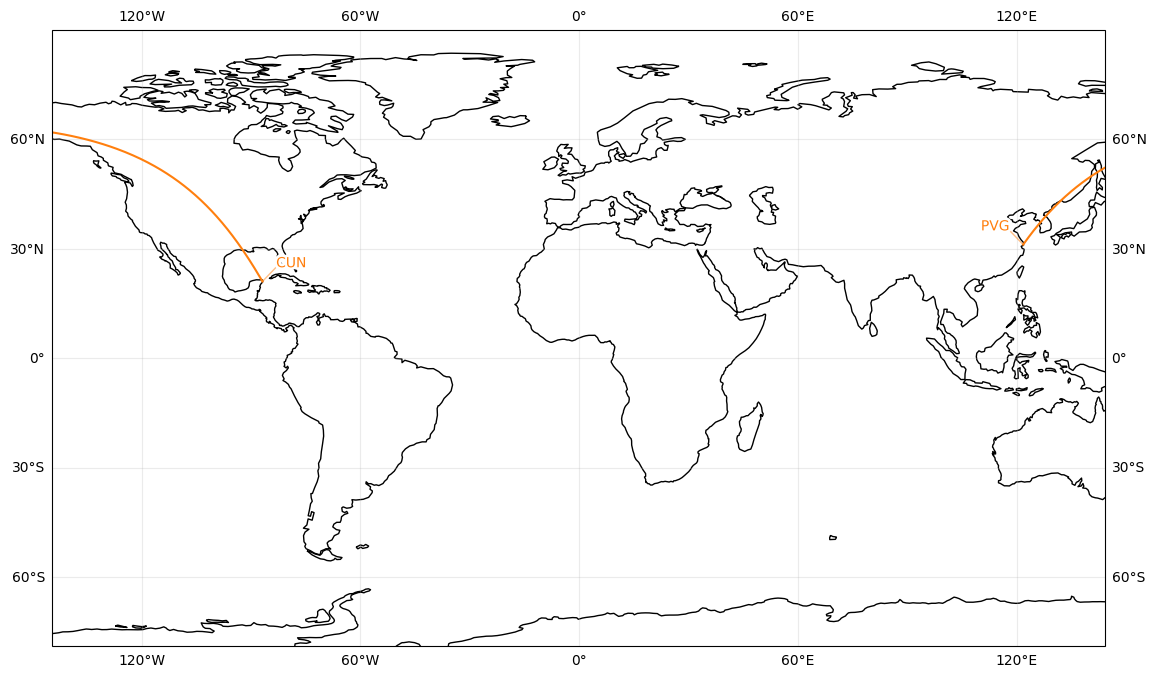

In [ ]:
import random


if __name__ == "__main__":
    print('\n')
    print("RecoverAI Agent: Running test case scenario...")
    print('\n')

    # Load airport data
    with open('airport_data.json', 'r') as f:
        airports_data = json.load(f)

    # Instantiate agents
    rma = ResourceManagementAgent(airports_data)
    llm_assistant = LLM_Assistant()
    ai_agent = AI_Agent(rma, airports_data)



    # Select a flight and passenger for testing
    (passenger_pnr, original_flight, origin, destination, departure_time,
    arrival_time_str, end_time_str) = ai_agent.select_flight_and_passenger()


    ### rma.find_alternative_flight
    alternative_flight = find_alternative_flight(passenger_pnr, original_flight)




    if passenger_pnr and original_flight:
        #ai_agent.run_test_case(passenger_pnr, original_flight)
        ai_agent.run_test_case(passenger_pnr, original_flight)

        # Get the passenger object using the PNR
        passenger_object = get_passenger_by_pnr(passenger_pnr)


        # Check if passenger object is found
        if passenger_object:
            print('\n')
            #print(llm_assistant.generate_response(
            #    "rebooking", flight_number=alternative_flight, departure_time=original_flight['departure_time'], passenger=passenger_object  # Pass the passenger object instead of PNR
            #))
        else:
            print(f"RecoverAI Agent: Unable to generate response due to missing passenger details for PNR: {passenger_pnr}")
